### ADNI Initial preprep, registration, nifti conversion, matching

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from natsort import natsorted

In [3]:
adni_dir = "/home/s2208943/datasets/ADNI300/"
spreadsheet_dir = adni_dir
os.listdir(spreadsheet_dir)

['ADNI300_selected_data',
 'ADNI_300_Variables_for_Analysis.xlsx',
 'ADNI_300_Sample_MVH_ratings.xlsx',
 'ADNI_data_300sample_Fazekas.csv',
 'ADNI_flair',
 'ADNI_data']

In [4]:
len(os.listdir(spreadsheet_dir + "ADNI_data/"))

302

In [5]:
os.listdir(spreadsheet_dir + "ADNI_data")[0:5]

['022_S_4173', '041_S_4041', '031_S_4218', '037_S_4302', '022_S_4444']

In [6]:
os.listdir(spreadsheet_dir + "ADNI_flair/ADNI/" + "016_S_4951/Sagittal_3D_FLAIR/2019-05-23_07_59_29.0/S830317")

['ADNI_016_S_4951_MR_Sagittal_3D_FLAIR__br_raw_20190605135331763_96_S830317_I1173064.nii']

In [7]:
os.listdir(spreadsheet_dir + "ADNI_flair/ADNI/" + "002_S_6007/Sagittal_3D_FLAIR/2017-03-31_10_40_49.0/S551367")

['ADNI_002_S_6007_MR_Sagittal_3D_FLAIR__br_raw_20170403113623237_17_S551367_I835744.nii']

In [8]:
t1_match_ds = pd.read_csv(spreadsheet_dir + "ADNI_data_300sample_Fazekas.csv", header=None)

In [9]:
t1_match_ds

,0,1
0,ADNI_002_S_0729,20110817
1,ADNI_002_S_1155,20111222
2,ADNI_002_S_1261,20110315
3,ADNI_002_S_1280,20110505
4,ADNI_002_S_2010,20101022
...,...,...
287,ADNI_941_S_4255,20111219
288,ADNI_941_S_4292,20111205
289,ADNI_941_S_4365,20111129
290,ADNI_941_S_4376,20111209


### TODO


- [x] copy over all the T1 images that I am currently missing sad times.
- [x] find a matching t1 for each flair that I identify
- [x] can I use the ICV: ans: yes but they used freesurfer and its very blocky, so I think I will use Bet which looks better. (I will use the fancy flag, but beware it will take forever aha)
- [x] write a script to convert each flair to .nii.gz and save it in the existing location.
- [x] split code up into methods
- [x] write code to register the T1s to the FLAIRs
- [x] check all t1s have been successfully registered
- [x] put code form this notebook into twaidata folder proper for keeping.
- [x] write code to register the ICV to the same space as the flair and registered t1 (so orient first then do final transform)
- [x] some flairs had multiple folders with 'flair' in name. see if searching those yields more exact matches for date.
- [x] comment the flair code so that I actually understand what it does, and do the same for t1, so it doesn't just look like a bungle later on.

### Building the spreadsheet for preprocessing the ADNI data (just the 300 with labelled fazekas)

In [10]:
# I need to check that the ICVs are in the same space as the flairs...

In [11]:
def match_flair_scans_to_annotation_date_spreadsheet(annotation_date_ds):

    ID_flair_matches = {}
    ID_date_matches = {}
    flair_folder = adni_dir + "ADNI_data/"
    fails = 0
    partial_successes = 0

    for idx in range(len(annotation_date_ds)):
        # ID is of form ADNI_<code> where <code> could be 002_S_0729 for example
        ID = t1_match_ds.iloc[idx][0]
        ID_code = "_".join(ID.split("_")[1:])

        scan_date = str(t1_match_ds.iloc[idx][1])
        scan_date_split = f"{scan_date[0:4]}-{scan_date[4:6]}-{scan_date[6-8]}"

        # get the folder for the particular individual
        ind_folder = f"{flair_folder}{ID_code}/"
        if not os.path.exists(ind_folder):
            print(f"failed: NO ID match for {ID}, {scan_date}: ind_folder: {ind_folder}")
            fails += 1
            continue

        # within the individual folder, look for any folder containing flair
        sub_ind_folders = os.listdir(ind_folder)
        flair_ind_folders = []
        for f in sub_ind_folders:
            if os.path.isdir(ind_folder + f) and 'flair' in f.lower():
                flair_ind_folders.append(f"{ind_folder}{f}/")

        if len(flair_ind_folders) == 0:
            print(f"failed: no flair folder for {ID}")
            fails += 1
            continue

        # within the flair folder, there are separate folders for each date at which
        # a scan is taken.
        flair_dates = [(date, fif) for fif in flair_ind_folders for date in os.listdir(fif)]
        # print(flair_dates)

        selected_flair_folder = None
        selected_date = None
        for (fdate, fif) in flair_dates:
            if scan_date_split in fdate:
                selected_flair_folder = f"{fif}{fdate}/"
                selected_date = fdate
                break

        # if we don't find an exact match for the date, try matching for the same year and month
        if selected_flair_folder == None:
            print(scan_date_split[0:7])
            # try matching on only year and month
            for (fdate, fif) in flair_dates:
                if scan_date_split[0:7] in fdate:
                    selected_flair_folder = f"{fif}{fdate}/"
                    selected_date = fdate
                    partial_successes += 1
                    break
                    
        # if we don't find a match for year and month, try year only
        # with the inclusion of this rule, we get no fails when trying to find a matching flair.
        # nice. however, I should inform maria that I have done this....
        if selected_flair_folder == None:
            print(scan_date_split[0:4])
            # try matching on only year and month
            for (fdate, fif) in flair_dates:
                if scan_date_split[0:4] in fdate:
                    selected_flair_folder = f"{fif}{fdate}/"
                    selected_date = fdate
                    partial_successes += 1
                    break

        if selected_flair_folder == None:
            print(f"failed: no date match for {ID}, {scan_date}")
            print(f"target: {scan_date_split}, given dates: {[d[0] for d in flair_dates]}")
            fails += 1
            continue
            
        # within each date folder, there is a single folder with a uid as its name.
        # we select this folder and finally, we can search for the flair folder inside.
        # we select the .hdr file, which nibabel will use to automatically load the corresponding
        # .img file.
        uid_flair_folder = selected_flair_folder + os.listdir(selected_flair_folder)[0]
        uid_files = os.listdir(uid_flair_folder)
        flair_file = None
        for f in uid_files:
            if ".hdr" in f:
                flair_file = f"{uid_flair_folder}/{f}"

        if flair_file == None:
            print(f"failed: couldn't find flair in date subfolder: {ID}")
            fails += 1

        #print(f"success: {ID}: {flair_file}")
        print("success")

        #print(ID, scan_date)
    
        ID_flair_matches[ID] = flair_file
        ID_date_matches[ID] = selected_date.replace('-', '')[0:8]
    
    return ID_flair_matches, ID_date_matches, fails, partial_successes

In [14]:
ID_flair_matches, ID_date_matches, fails, partial_successes = match_flair_scans_to_annotation_date_spreadsheet(t1_match_ds)

success
success
success
success
success
2011-12
success
success
success
success
success
success
success
success
success
success
success
success
success
success
2011-11
success
success
success
success
success
success
2011-11
success
success
success
success
success
success
2012-10
2012
success
success
2012-03
2012
success
success
success
success
success
success
success
success
success
2011-11
success
2011-10
success
success
2011-12
success
success
2012-07
2012
success
success
success
success
success
success
2012-11
2012
success
success
success
success
success
success
success
success
success
2012-10
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
2012-10
success
success
2010-12
2010
success
success
success
2011-11
success
2011-11
success
2012-09
2012
success
success
success
success
2011-11
success
2011-09
2011
success
success
2012-08
success
success
success
success
success
success
2011-12
2011
success
success


In [15]:
ID_flair_matches['ADNI_002_S_0729']

'/home/s2208943/datasets/ADNI300/ADNI_data/002_S_0729/Axial_T2-FLAIR/2011-08-16_15_48_57.0/S119184/ADNI_002_S_0729_MR_Axial_T2-FLAIR_br_raw_20110817105000870_10_S119184_I251174.hdr'

In [16]:
ID_date_matches['ADNI_002_S_0729']

'20110816'

In [17]:
fails, partial_successes

(0, 51)

In [18]:
len(ID_flair_matches)

292

In [19]:
len(ID_date_matches)

292

In [25]:
adni_dir

'/home/s2208943/datasets/ADNI300/'

### Find a matching for each t1

In [32]:
def match_t1_to_flair_date(ID_to_flair_date_map):
    ID_t1_matches = {}
    missing_ids = []
    fails = 0
    
    # t1 folder now the same as the flair folder
    t1_folder = adni_dir + "ADNI_data/"
    T1_ids = os.listdir(t1_folder)
    
    for ID, scan_date in ID_to_flair_date_map.items():
        # ID is of form ADNI_<code> where <code> could be 002_S_0729 for example
        ID_code = "_".join(ID.split("_")[1:])
        scan_date_split = f"{scan_date[0:4]}-{scan_date[4:6]}-{scan_date[6-8]}"
        
        if ID_code not in T1_ids:
            missing_ids.append(ID)
            print(f"failed, missing ID: {ID}")
            fails += 1
            
        # I should now be able to find an exact match for each flair that I have found
        # within the individual folder, look for any folder containing MPRAGE
        ind_folder = f"{t1_folder}{ID_code}/"
        sub_ind_folders = os.listdir(ind_folder)
        mprage_ind_folders = []
        for f in natsorted(sub_ind_folders):
            if os.path.isdir(ind_folder + f) and ('mprage' in f.lower() or 'mp-rage' in f.lower()):
                mprage_ind_folders.append(f"{ind_folder}{f}/")

        if len(mprage_ind_folders) == 0:
            print(f"failed: no t1 folder for {ID}")
            fails += 1
            continue
            
        selected_date_folder = None
        for mprage_folder in mprage_ind_folders:
            date_folders = [f"{mprage_folder}{date}/" for date in os.listdir(mprage_folder)]
            for fdate in date_folders:
                if scan_date_split in fdate:
                    selected_date_folder = fdate
                    break
            if selected_date_folder:
                break
        
        if selected_date_folder == None:
            print(f"failed: no date match for {ID} and flair date {scan_date}")
            fails += 1
            continue
        
        # each date folder contains a single folder with a uid. All files are within
        # that folder
        uid_folder = f"{selected_date_folder}{os.listdir(selected_date_folder)[0]}/"
        uid_files = os.listdir(uid_folder)
        t1_file = None
        for f in uid_files:
            if ".hdr" in f:
                t1_file = f"{uid_folder}/{f}"

        if t1_file == None:
            print(f"failed: couldn't find flair in date subfolder: {ID}")
            fails += 1
            continue
            
        else:
            ID_t1_matches[ID] = t1_file
            print(f"success {ID}")
            
        # break
    print(f"fails: {fails}")
    
    return ID_t1_matches

In [33]:
ID_date_matches['ADNI_016_S_4584']

'20121029'

In [34]:
# failed: no flair folder for ADNI_016_S_4584
# failed: no flair folder for ADNI_016_S_4591 # so I think maybe these are in the sag folder, but for now I can skip them.

In [35]:
#ID_date_matches

In [36]:
ID_t1_matches = match_t1_to_flair_date(ID_date_matches)

success ADNI_002_S_0729
success ADNI_002_S_1155
success ADNI_002_S_1261
success ADNI_002_S_1280
success ADNI_002_S_2010
success ADNI_002_S_4213
success ADNI_002_S_4225
success ADNI_002_S_4229
success ADNI_002_S_4237
success ADNI_002_S_4262
success ADNI_002_S_4270
success ADNI_002_S_4447
success ADNI_002_S_4473
success ADNI_002_S_4521
success ADNI_002_S_4654
success ADNI_006_S_4150
success ADNI_006_S_4153
success ADNI_006_S_4192
success ADNI_006_S_4357
success ADNI_006_S_4363
success ADNI_006_S_4485
success ADNI_006_S_4679
success ADNI_006_S_4713
success ADNI_006_S_4960
success ADNI_009_S_2208
success ADNI_009_S_4324
success ADNI_009_S_4359
success ADNI_009_S_4388
success ADNI_009_S_4543
success ADNI_009_S_4612
success ADNI_009_S_4741
success ADNI_010_S_4345
success ADNI_011_S_0021
success ADNI_011_S_0023
success ADNI_011_S_2274
success ADNI_011_S_4075
success ADNI_011_S_4105
success ADNI_011_S_4120
success ADNI_011_S_4222
success ADNI_011_S_4235
success ADNI_011_S_4278
success ADNI_011

In [686]:
# ID_t1_matches, ID_date_matches

### Converting to nifti

In [807]:
def convert_to_nifti_format(hdr_in_path, out_path):
    nib_img = nib.load(hdr_in_path)
    
    # the .img file isn't actually loaded
    # until we request the data, which causes a problem when trying to save the data...
    # but here I convert all the images to float 32 anyway and create a new image which avoids
    # the problem
    data = nib_img.get_fdata().astype(np.float32)
    new_nib_img = nib.Nifti1Image(data, affine=nib_img.affine, header=nib_img.header)
    
    #
    nib.save(new_nib_img, out_path)

In [8]:
converted_nifti_folder = "/home/s2208943/ipdis/data/ADNI_data/selected_nifti_300/"

In [809]:
def convert_adni_folders_to_nifti(ID_flair_matches, ID_t1_matches, ID_date_matches, out_folder, force=False, force_individuals=False):
    # this function takes in the outputs from the adni flair and t1 matchers that crawl the adni folder and find id, date matching pairs.
    # it then for each of those identified flair and t1 images, converts them from analyze 7.5 to nifti using nibabel
    # and puts them in a new folder afterwards. not all ids that have a flair may have a matching t1 at the moment (due to different protocol?)
    # at the moment 2 of the 200 adni sample are skipped.
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    else:
        if not force:
            print("folder already exists. stopping. set force to true to overwrite")
            return
        
    for ID, date in tqdm(ID_date_matches.items(), position=0, leave=True):
        flair_file = ID_flair_matches[ID]
        if ID in ID_t1_matches:
            t1w_file = ID_t1_matches[ID]
        else:
            continue
        
        subfolder = f"{out_folder}{ID}_{date}"
        if not os.path.exists(subfolder):
            os.mkdir(subfolder)
        
        flair_out = f"{subfolder}/flair.nii.gz"
        t1w_out = f"{subfolder}/t1w.nii.gz"
        
        if force_individuals or not os.path.exists(flair_out):
            convert_to_nifti_format(flair_file, flair_out)
        if force_individuals or not os.path.exists(t1w_out):
            convert_to_nifti_format(t1w_file, t1w_out)

In [810]:
convert_adni_folders_to_nifti(ID_flair_matches, ID_t1_matches, ID_date_matches, converted_nifti_folder, force=True, force_individuals=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [07:56<00:00,  1.63s/it]


In [710]:
len(os.listdir(converted_nifti_folder))

290

### Registering the T1w to the space of the FLAIR

In [36]:
ADNI_nifti_ids = os.listdir(converted_nifti_folder)

In [37]:
converted_nifti_folder

'/home/s2208943/ipdis/data/ADNI_data/selected_nifti_300/'

In [342]:
example_id_folder = "ADNI_023_S_4502_20121025"#ADNI_nifti_ids[100]
example_files = os.listdir(converted_nifti_folder + example_id_folder)
example_folder = converted_nifti_folder + example_id_folder + "/"
flair_example = example_folder + [f for f in example_files if 'flair' in f][0]
t1_example = example_folder + [f for f in example_files if 't1w' in f][0]

In [343]:
flair_example, t1_example

('/home/s2208943/ipdis/data/ADNI_data/selected_nifti_300/ADNI_023_S_4502_20121025/flair.nii.gz',
 '/home/s2208943/ipdis/data/ADNI_data/selected_nifti_300/ADNI_023_S_4502_20121025/t1w.nii.gz')

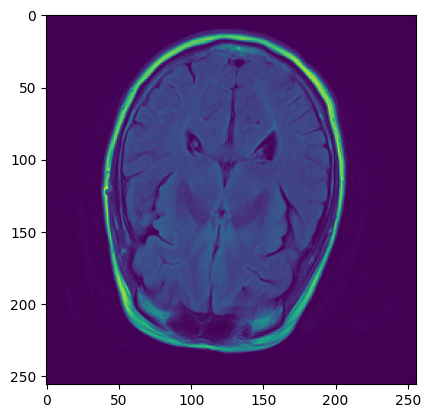

In [344]:
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(flair_example))[20])

In [345]:
"""
WARNING: this is the old version of the regisration code. it doesn't work very well.
at a later stage I need to learn about brain registration properly,
but for now, this is the older and actually more fancy version, with the multiscaling
but the multiscaling was really bad.
"""
def old_register_two_images(fixed_image_path, moving_image_path):
    # requires 32 bit float type for 
    fixed_img = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving_img = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    
    # ensure direction and origin the same as fixed image.
    # fixing orientation essential to ensuring the images are registered
    # the right way round with one another (e.g so it doesn't morph one image
    # upside down onto another.
    moving_img.SetDirection(fixed_img.GetDirection())
    moving_img.SetOrigin(fixed_img.GetOrigin())
    
    # initial transform aligns the centres
    initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                      moving_img, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)
    
    
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings. # not sure if the sampling strategy stuff
    # is even used for mean squares... but this seems to work well.
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # dont transform in place (useful for debugging)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(fixed_img, moving_img)
    
    # compute the final transform on the image
    # to transform a binary mask change sitk.sitkLinear to sitk.sitkNearestNeighbor
    registered_img = sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())
    
    return fixed_img, registered_img

In [346]:
"""
newer version, removed the multi scale stuff, increased the sampling percentage and
switched to geometry instead of moments for initial transform.
"""

def register_two_images(fixed_image_path, moving_image_path):
    # requires 32 bit float type for 
    fixed_img = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving_img = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    
    # ensure direction and origin the same as fixed image.
    # fixing orientation essential to ensuring the images are registered
    # the right way round with one another (e.g so it doesn't morph one image
    # upside down onto another.
    moving_img.SetDirection(fixed_img.GetDirection())
    moving_img.SetOrigin(fixed_img.GetOrigin())
    
    # initial transform aligns the centres
    initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                      moving_img, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings. # not sure if the sampling strategy stuff
    # is even used for mean squares... but this seems to work well.
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.03)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    # registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # dont transform in place (useful for debugging)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(fixed_img, moving_img)
    # final_transform = initial_transform
    
    # compute the final transform on the image
    # to transform a binary mask change sitk.sitkLinear to sitk.sitkNearestNeighbor    
    registered_img = sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())
    
    return fixed_img, registered_img

In [347]:
flair_img, t1_registered_image = register_two_images(flair_example, t1_example)

In [348]:
flair_img.GetSpacing(), t1_registered_image.GetSpacing()

((0.859375, 0.859375, 5.0), (0.859375, 0.859375, 5.0))

In [349]:
fixed_arr = sitk.GetArrayFromImage(flair_img)
moving_arr = sitk.GetArrayFromImage(t1_registered_image)

In [350]:
fixed_arr.shape, moving_arr.shape

((35, 256, 256), (35, 256, 256))

In [351]:
islice = 20

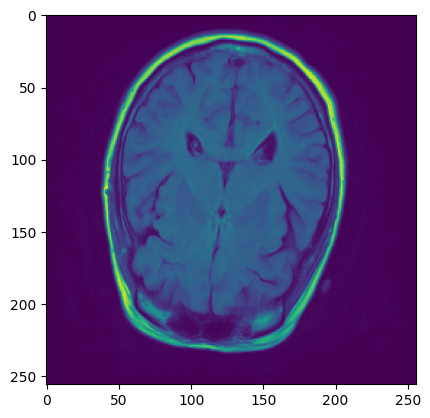

In [352]:
plt.imshow(fixed_arr[islice] + moving_arr[islice])

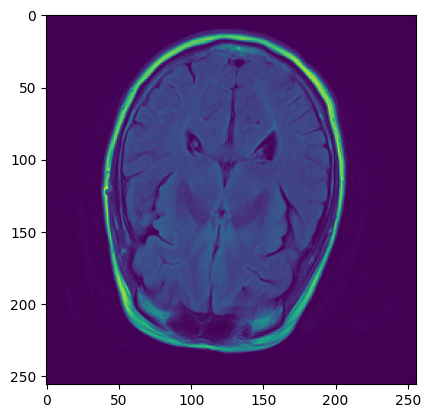

In [353]:
plt.imshow(fixed_arr[islice])

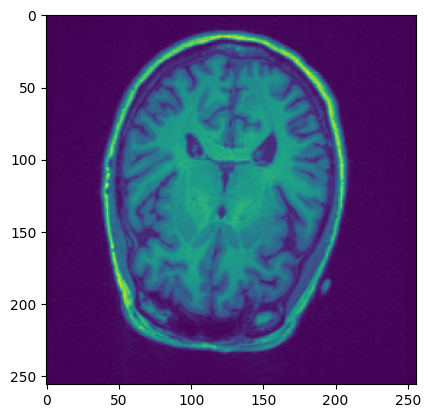

In [354]:
plt.imshow(moving_arr[islice])

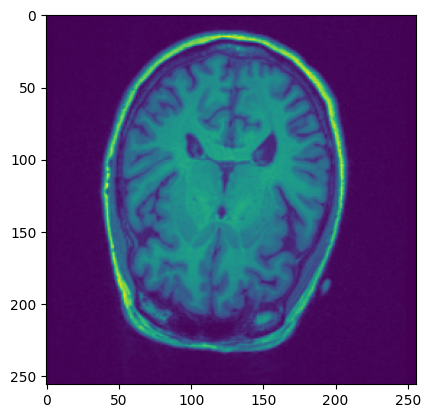

In [355]:
plt.imshow(fixed_arr[islice] + moving_arr[islice]*20)

In [356]:
def register_all_t1_to_flair(imgs_folder, force_individuals=False):
    # imgs_folder is a folder containing a folder per each ID-date pair.
    # inside each of those folders should be a t1w.nii.gz and flair.nii.gz image. 
    # this method loops over each folder, registers the t1 to the flair and puts
    # a t1w_registered.nii.gz in each folder. Nice.
    
    subfolders = os.listdir(imgs_folder)
    
    for subfolder in tqdm(subfolders, position=0, leave=True):
        folder_path = os.path.join(imgs_folder, subfolder)
        t1_registered_path = os.path.join(folder_path, "t1w_registered.nii.gz")
        if not force_individuals and os.path.exists(t1_registered_path):
            continue
        
        flair_path = os.path.join(folder_path, "flair.nii.gz")
        t1_path = os.path.join(folder_path, "t1w.nii.gz")
        
        _, registered_t1 = register_two_images(flair_path, t1_path)
        
        sitk.WriteImage(registered_t1, t1_registered_path)
        

In [358]:
register_all_t1_to_flair(converted_nifti_folder, force_individuals=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [17:05<00:00,  3.54s/it]


### Check that the registering has worked
ANS: yes, looks good to me!!

In [14]:
converted_nifti_folder="/home/s2208943/datasets/ADNI300/ADNI300_selected_data/"
ADNI_nifti_ids = os.listdir(converted_nifti_folder)
example_id_folder = ADNI_nifti_ids[5]
example_files = os.listdir(converted_nifti_folder + example_id_folder)
example_folder = converted_nifti_folder + example_id_folder + "/"
flair_example = example_folder + [f for f in example_files if 'flair' in f][0]
t1_example = example_folder + [f for f in example_files if 't1w_registered' in f][0]

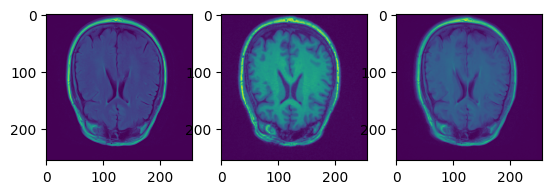

In [15]:
islice = 20
plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(flair_example))[islice])
plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(t1_example))[islice])
plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(flair_example))[islice] + sitk.GetArrayFromImage(sitk.ReadImage(t1_example))[islice])

### Building the csv spreadsheet so that I can preprocess the ADNI data

In [955]:
# should be in format
# <input file path>,<output file folder>,<output_id>_<image mode>,is_label
# 50,Singapore/50/orig/FLAIR.nii.gz,Singapore/imgs/,FLAIR,False

id_folders = os.listdir(converted_nifti_folder)
output_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300/"
    
with open("ADNI_300_preprocessing_io_table.csv", 'w') as f:
    for idx, ID in enumerate(natsorted(id_folders)):
        example_files = os.listdir(converted_nifti_folder + ID)
        example_folder = converted_nifti_folder + ID + "/"
        flair_example = example_folder + [f for f in example_files if 'flair' in f][0]
        # uses the registered version of the t1.
        t1_example = example_folder + [f for f in example_files if 't1w_registered' in f][0]
        
        f.write(f"{idx},{ID},{flair_example},{output_folder},FLAIR,False\n")
        f.write(f"{idx},{ID},{t1_example},{output_folder},T1,False\n")

### seeing if the full preprocessing has worked

ans: YES! it has :)

In [956]:
preprop_dir = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300/"
os.listdir(preprop_dir)

['ADNI_002_S_0729_20110816_FLAIR_BET.nii.gz',
 'ADNI_002_S_0729_20110816_FLAIR_BET_mask.nii.gz',
 'ADNI_002_S_0729_20110816_FLAIR_NORMALIZE.nii.gz',
 'ADNI_002_S_0729_20110816_FLAIR.nii.gz',
 'ADNI_002_S_0729_20110816_T1_BIAS_CORR.nii.gz',
 'ADNI_002_S_0729_20110816_T1_BET.nii.gz',
 'ADNI_002_S_0729_20110816_T1_NORMALIZE.nii.gz',
 'ADNI_002_S_0729_20110816_T1.nii.gz']

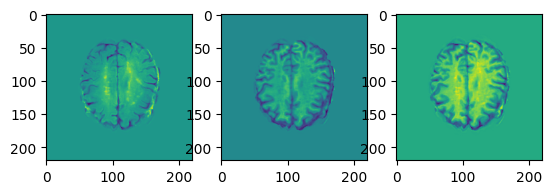

In [959]:
islice = 38
plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(preprop_dir + 'ADNI_002_S_0729_20110816_FLAIR.nii.gz'))[islice])
plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(preprop_dir + 'ADNI_002_S_0729_20110816_T1.nii.gz'))[islice])
plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(preprop_dir + 'ADNI_002_S_0729_20110816_FLAIR.nii.gz'))[islice] + sitk.GetArrayFromImage(sitk.ReadImage(preprop_dir + 'ADNI_002_S_0729_20110816_T1.nii.gz'))[islice])

### Examining the ADNI clin data and fazekas rating spreadsheets

In [5]:
variables_ds = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
variables_ds

,Unnamed: 0,GENERAL INFO,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,BASELINE BRAIN MEASUREMENTS (% of ICV),Unnamed: 8,Unnamed: 9,...,Unnamed: 12,IMAGE ANALYSIS FINDINGS,Unnamed: 14,Unnamed: 15,MEDICAL HISTORY,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,Patient ID,DX.bl,AGE,PTGENDER,PTEDUCAT,PTRACCAT,APOE4,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,...,MidTemp_bl %,BMB Y1 Count,BMB Y2 Count,BMB Y3 Count,VSBPDIA,VSBPSYS,VSPULSE,BMI,CV RISK FACTORS,E-M RISK FACTORS
1,002_S_0729,2,65.1,2,16,5,1,1.292191,0.472993,71.867729,...,1.333163,0,1,1,57,124,56,22.810281,1,0
2,002_S_1155,2,57.8,1,20,5,0,0,0,0,...,0,0,0,1,72,105,54,23.555498,1,1
3,002_S_1261,0,71.1,2,16,5,0,2.157239,0.418533,67.676511,...,1.325454,1,1,1,54,108,56,22.935921,2,0
4,002_S_1280,0,70.7,2,14,5,1,1.426753,0.463987,67.38575,...,1.225333,3,2,2,85,133,71,38.625486,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177,126


In [27]:
variables_ds.keys()

Index(['Unnamed: 0', 'GENERAL INFO ', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'BASELINE BRAIN MEASUREMENTS (% of ICV)',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'IMAGE ANALYSIS FINDINGS ', 'Unnamed: 14', 'Unnamed: 15',
       'MEDICAL HISTORY', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [10]:
variables_ds.iloc[0]

Unnamed: 0                                      Patient ID
GENERAL INFO                                         DX.bl
Unnamed: 2                                             AGE
Unnamed: 3                                        PTGENDER
Unnamed: 4                                        PTEDUCAT
Unnamed: 5                                        PTRACCAT
Unnamed: 6                                           APOE4
BASELINE BRAIN MEASUREMENTS (% of ICV)     Ventricles_bl %
Unnamed: 8                                Hippocampus_bl %
Unnamed: 9                                 WholeBrain_bl %
Unnamed: 10                                Entorhinal_bl %
Unnamed: 11                                  Fusiform_bl %
Unnamed: 12                                   MidTemp_bl %
IMAGE ANALYSIS FINDINGS                       BMB Y1 Count
Unnamed: 14                                   BMB Y2 Count
Unnamed: 15                                   BMB Y3 Count
MEDICAL HISTORY                                    VSBPD

In [25]:
variables_ds['Unnamed: 21'].values

array(['E-M RISK FACTORS', 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, nan, nan,

In [11]:
ratings_ds = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
ratings_ds

,Patient ID,Image_year,PVS_BG,PVS_CS,Unnamed: 4,Image_year.1,WMH_PV,WMH_Deep,Total,Obs
0,002_S_0729,2013.0,4.0,4.0,NaN,2011.0,2.0,2.0,4.0,NaN
1,002_S_1155,2012.0,3.0,3.0,NaN,2011.0,1.0,0.0,1.0,NaN
2,002_S_1261,2014.0,1.0,3.0,NaN,2011.0,1.0,1.0,2.0,NaN
3,002_S_1280,2013.0,3.0,3.0,NaN,2011.0,3.0,2.0,5.0,NaN
4,002_S_2010,2013.0,1.0,1.0,NaN,2010.0,1.0,1.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
306,DWMH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,0 = absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,1 = discrete diffuse lesions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,2 = beginning of confluence of foci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
(ratings_ds['WMH_PV'].values)

array([ 2.,  1.,  1.,  3.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,
        1.,  1., nan,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        2.,  1.,  2.,  2.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,  3.,
        2.,  2.,  3.,  1.,  1.,  2.,  2.,  1.,  1.,  0.,  1.,  1.,  2.,
        1.,  0.,  2.,  2.,  1.,  0.,  3.,  2.,  1.,  1.,  2.,  2.,  2.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,
        1.,  2.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
        1., nan,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  2.,  0.,  1.,
        2.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  0.,  0.,  1.,  2.,  1.,  2.,  3.,
        1.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  2.,
        3.,  1.,  1.,  0.,  1.,  1.,  0.,  2.,  1.,  2.,  2.,  2.,  1.,
        2.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0